# Impact of $c_s^2$ on observables

Usual dark energy models assume an effective sound speed of $c_s^2 = 1$. What is the impact of another choice, *e.g.* $c_s^2 = 0$?

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import camb

matplotlib.rcParams["mathtext.fontset"] = "stix"
matplotlib.rcParams["font.family"] = "STIXGeneral"
matplotlib.rcParams["legend.framealpha"] = 0.0

In [ ]:
# Cosmological parameters for examples
H0 = 67
omegam = 0.319
omegab = 0.049
As = 2.1e-9
ns = 0.96
tau = 0.07
w0 = -0.8
wa = 0

# Derived parameters
h = H0/100
omegac = omegam - omegab
ombh2 = omegab*h*h
omch2 = omegac*h*h

# k, z grid for power spectrum
ks = np.logspace(-3, 0.1, 200)
scale_factors = np.logspace(-5, 0, 200)
redshifts = 1/scale_factors - 1

In [ ]:
cases = [
    {"name": "quint", "label": "$c_s^2 = 1$", "cs2_type": camb.dark_energy.Cs2_Constant, "cs2_0": 0, "cs2_1": 0},
]

def get_observables(case):
    cosmo = camb.set_params(
        H0=H0, ombh2=ombh2, omch2=omch2, As=As, ns=ns, tau=tau,
        num_nu_massless=3.044, WantTransfer=True, w0=w0, wa=wa, dark_energy_model="fluid",
        cs2_type=case["cs2_type"], cs2_0=case["cs2_0"], cs2_1=case["cs2_1"]
    )
    cosmo.set_for_lmax(2000, lens_potential_accuracy=1)
    cosmo.set_matter_power(redshifts=redshifts, kmax=20, silent=True, nonlinear=True)
    results = camb.get_results(cosmo)
    P_lin = results.get_matter_power_interpolator(nonlinear=None).P(0, ks)
    fsigma8 = results.get_fsigma8()
    cl_tt = results.get_lensed_scalar_cls(CMB_unit='muK')[:,0]
    cl_ee = results.get_lensed_scalar_cls(CMB_unit='muK')[:,1]
    cl_te = results.get_lensed_scalar_cls(CMB_unit='muK')[:,3]
    cl_pp = results.get_lens_potential_cls(lmax=2000)[:,0]
    ev    = results.get_redshift_evolution(ks, redshifts, ['delta_cdm', 'delta_tot', 'delta_tot_de']) # NOTE: tot here does not include DE, tot_de does
    rhos  = results.get_background_densities(a=1/(1 + redshifts))
    rho_de    = rhos["de"]
    rho_no_de = rhos["cdm"] + rhos["baryon"] + rhos["neutrino"]
    # rho_no_de = rho_tot - rho_de
    delta_cdm   = ev[:, :, 0]
    delta_no_de = ev[:, :, 1]
    delta_tot   = ev[:, :, 2]
    delta_de = (delta_tot - delta_no_de)*rho_no_de/rho_de
    return {"P_lin": P_lin, "fsigma8": fsigma8, "cl_tt": cl_tt, "cl_ee": cl_ee, "cl_te": cl_te, "cl_pp": cl_pp, "delta_cdm": delta_cdm, "delta_de": delta_de, "rhos": rhos}

data = {}
for case in cases:
    data[case["name"]] = get_observables(case)

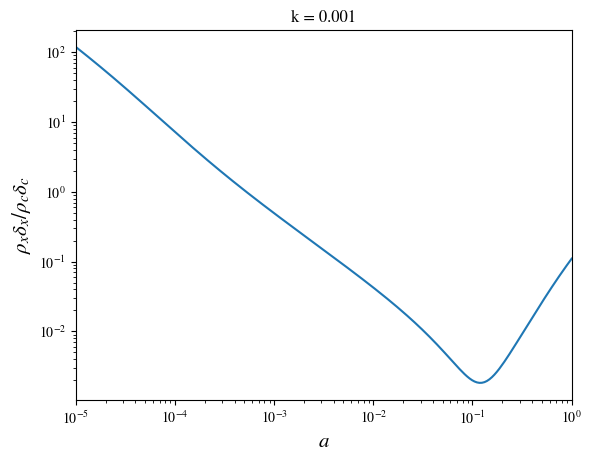

In [4]:
# Plot transfer function
k_index = 0
for case in cases:
    results = data[case["name"]]
    plt.loglog(scale_factors, np.abs(results["delta_de"][k_index]/results["delta_cdm"][k_index])*results["rhos"]["de"]/results["rhos"]["cdm"])
plt.title(f"k = {ks[k_index]}")
plt.xlabel("$a$", fontsize=15)
plt.xlim([1e-5, 1])
plt.ylabel(r"$\rho_x\delta_x/\rho_c\delta_c$", fontsize=15)
plt.savefig("test.png")